In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import torch.utils.data as data
import random
import time
from tqdm import tqdm
import math

In [2]:
def unflatten_image(image_list):
    new_list = []
    for image in image_list:
        new_list.append(image.reshape(1,32,32))

    return np.array(new_list, dtype=np.float64)

In [3]:
def load_pickle(path):
    with open(path, 'rb') as fo:
        data = pickle.load(fo)

    data = unflatten_image(data)
    return data

In [4]:
class FaceDataset(data.Dataset):
    def __init__(self, image_list, label_list):
        self.images = image_list
        self.labels = label_list

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img = self.images[index]
        label = self.labels[index]


        return img, label

In [5]:
def make_layers(cfg, size):
    layers = []
    in_channels = 1

    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=size, padding=1)
            layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v

    return nn.Sequential(*layers)

def make_ffn(cfg, size):
    input_size = 32
    channel_size = cfg[0]
    
    for v in cfg:
        if v == 'M':
            input_size = math.floor(input_size/2)

        else:
            input_size = math.floor(input_size-size+3)

    return nn.Linear(channel_size * input_size * input_size, 2)

class CNN(nn.Module):
    def __init__(self, cfg, size):
        super().__init__()
        self.features = make_layers(cfg, size)
        self.fc_layer = make_ffn(cfg, size)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x
    

In [6]:
def train_model(net, train_loader, criterion, optimizer, num_epochs):
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    net.to(device)
    
    loss_arr = []
    start = time.time()
    net.train()
    
    for epoch in range(num_epochs):
        # print('Epoch {}/{}'.format(epoch+1, num_epochs))
        # print('--------------------')

        epoch_loss = 0.0
        
        for data, target in train_loader:
            data, target = data.to(device).float(), target.to(device)
            optimizer.zero_grad()
            output = net(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * data.size(0)
    
        # print('Loss: {:.4f}'.format(epoch_loss))
        epoch_loss = epoch_loss / len(train_loader.dataset)
        loss_arr.append(epoch_loss)

    training_time = time.time() - start


    return loss_arr, training_time

In [7]:
def evaluate(net, test_loader):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    net.to(device)
    net.eval()
    
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device).float(), target.to(device)
            output = net(data)

            preds = output.max(1, keepdim=True)[1]
            
            correct += preds.eq(target.view_as(preds)).sum().item()

    acc = correct / len(test_loader.dataset) * 100
    # print("Accuracy of Test Data: {}%".format(acc))

    return acc

In [8]:
def experiment():
    cfgs = [
    [8, 'M', 8, 'M'],
    [8, 8, 'M', 8, 'M'],
    [8, 8, 'M', 8, 8 ,'M'],
    [16, 'M', 16, 'M'],
    [16, 16, 'M', 16, 'M'],
    [16, 16, 'M', 16, 16,'M']
    ]

    for size in [3,5]:
        for num, cfg in enumerate(cfgs):
            channel = cfg[0]
            
            if num in [0,3]:
                layer = 2
            elif num in [1,4]:
                layer = 3
            else:
                layer = 4
            
            net = CNN(cfg, size)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.SGD(net.parameters(), lr = 1e-3, momentum=0.9)

            train_loss, training_time = train_model(net, train_dataloader, criterion, optimizer, 10)
            test_acc = evaluate(net, test_dataloader)
            
            plt.figure()
            plt.plot(np.array(train_loss), 'r', label='Accuray:{:.2f}%'.format(test_acc))
            plt.xlabel('Epochs')
            plt.ylabel('Loss')

            plt.title('Layer: {}, Filter: {}, Size: {}, Time:{:.2f}'.format(layer, channel, size, training_time))

            plt.legend(loc='upper right')

In [9]:
face = load_pickle('../data/faces_python.pkl')
non_face = load_pickle('../data/nonfaces_python.pkl')
face_label = np.ones(face.shape[0],dtype=np.int64)
non_face_label = np.zeros(non_face.shape[0], dtype=np.int64)

In [10]:
# I changed the ratio to 0.8, because I think the training dataset need a larger portion
train_test_ratio = 0.8

tmp1 = np.round(face.shape[0]*train_test_ratio).astype(int)

train_face_label = face_label[:tmp1]
test_face_label = face_label[tmp1:]
train_face = face[:tmp1,:,:]
test_face = face[tmp1:,:,:]

# Randomly sampling the non-face data 
random.seed(42)
sample_idx = random.sample(range(len(non_face)), len(face))
new_non_face = []
new_non_face_label = []
for idx in sample_idx:
    new_non_face.append(non_face[idx,:,:])
    new_non_face_label.append(non_face_label[idx])
new_non_face = np.array(new_non_face)
new_non_face_label = np.array(new_non_face_label)


tmp2 = np.round(new_non_face.shape[0]*train_test_ratio).astype(int)

train_non_face_label = new_non_face_label[:tmp2]
test_non_face_label = new_non_face_label[tmp2:]
train_non_face = new_non_face[:tmp2,:,:]
test_non_face = new_non_face[tmp2:,:,:]


train_image = np.concatenate((train_face, train_non_face), axis=0)
train_label = np.concatenate((train_face_label, train_non_face_label), axis=0)

test_image = np.concatenate((test_face, test_non_face), axis=0)
test_label = np.concatenate((test_face_label, test_non_face_label), axis=0)

In [11]:
train_dataset = FaceDataset(train_image, train_label)
test_dataset = FaceDataset(test_image, test_label)

In [12]:
batch_size = 128

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)

classes = ('non-face', 'face')

In [13]:
batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([128, 1, 32, 32])
tensor([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
        0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
        0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
        0, 0, 1, 1, 1, 0, 0, 1])


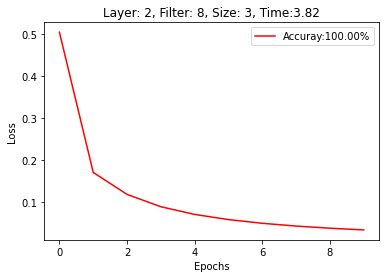

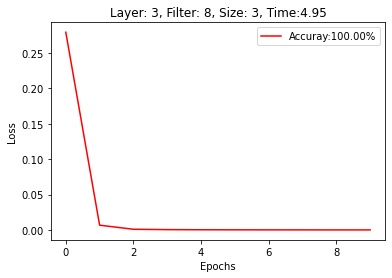

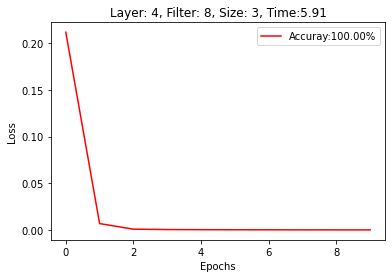

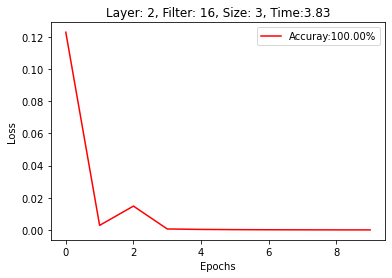

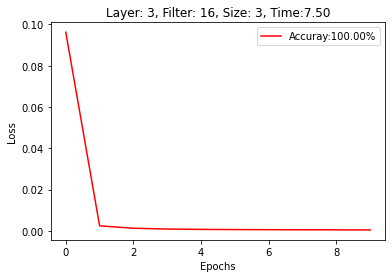

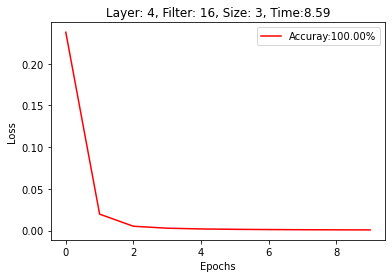

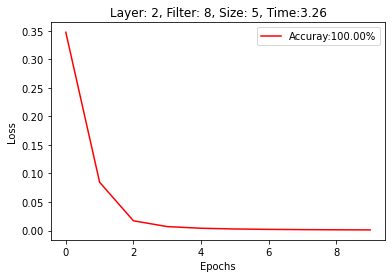

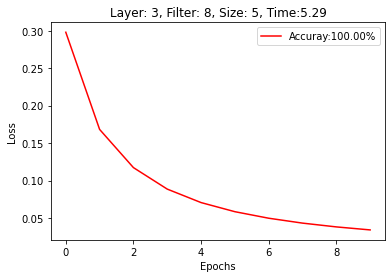

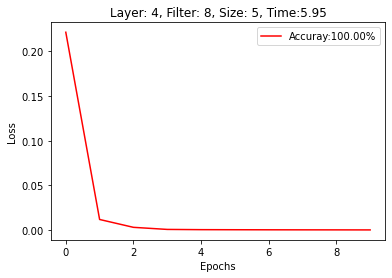

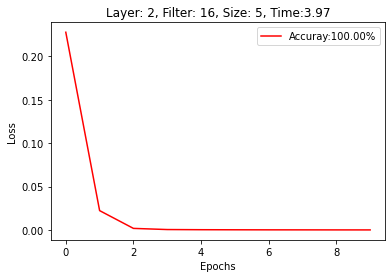

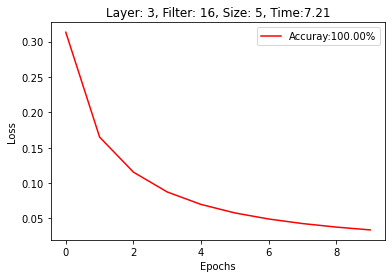

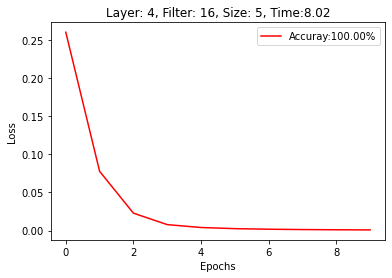

In [14]:
experiment()